# Boston 1970s House Price Prediction: A regression problem

In [50]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [51]:
boston_housing = keras.datasets.boston_housing
(train_data, train_labels), (test_data, test_labels) = boston_housing.load_data()

#Shuffle the training set
order = np.argsort(np.random.random(train_labels.shape))
train_data = train_data[order]
train_labels = train_labels[order]

#### The dataset contains 13 different features:

1. Per capita crime rate.
2. The proportion of residential land zoned for lots over 25,000 square feet.
3. The proportion of non-retail business acres per town.
4. Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).
5. Nitric oxides concentration (parts per 10 million).
6. The average number of rooms per dwelling.
7. The proportion of owner-occupied units built before 1940.
8. Weighted distances to five Boston employment centers.
9. Index of accessibility to radial highways.
10. Full-value property-tax rate per $10,000.
11. Pupil-teacher ratio by town.
12. 1000 * (Bk - 0.63) ** 2 where Bk is the proportion of Black people by town.
13. Percentage lower status of the population.


In [52]:
train_data[0]    #data is on different scales

array([7.8750e-02, 4.5000e+01, 3.4400e+00, 0.0000e+00, 4.3700e-01,
       6.7820e+00, 4.1100e+01, 3.7886e+00, 5.0000e+00, 3.9800e+02,
       1.5200e+01, 3.9387e+02, 6.6800e+00])

In [53]:
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
                'TAX', 'PTRATIO', 'B', 'LSTAT']

df = pd.DataFrame(train_data, columns=column_names)
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.07875,45.0,3.44,0.0,0.437,6.782,41.1,3.7886,5.0,398.0,15.2,393.87,6.68
1,4.55587,0.0,18.10,0.0,0.718,3.561,87.9,1.6132,24.0,666.0,20.2,354.70,7.12
2,0.09604,40.0,6.41,0.0,0.447,6.854,42.8,4.2673,4.0,254.0,17.6,396.90,2.98
3,0.01870,85.0,4.15,0.0,0.429,6.516,27.7,8.5353,4.0,351.0,17.9,392.43,6.36
4,0.52693,0.0,6.20,0.0,0.504,8.725,83.0,2.8944,8.0,307.0,17.4,382.00,4.63


## Normalize the data
> Although the model might converge without feature normalization, it makes training more difficult, and it makes the resulting model more dependent on the choice of units used in the input.



In [54]:
#Normalize the training data

mean = train_data.mean(axis=0)
std = train_data.std(axis=0)
train_data = (train_data - mean) / std
test_data = (test_data - mean) / std

train_data[0]    #everything is scaled between 0 and 1

array([-0.39725269,  1.41205707, -1.12664623, -0.25683275, -1.027385  ,
        0.72635358, -1.00016413,  0.02383449, -0.51114231, -0.04753316,
       -1.49067405,  0.41584124, -0.83648691])

In [55]:
def build_model():
    model = keras.Sequential([
        keras.layers.Dense(64, activation=tf.nn.relu, input_shape=(train_data.shape[1],)),
        keras.layers.Dense(64, activation=tf.nn.relu),
        keras.layers.Dense(1)    #notice how there is no softmax here for class probs as this is a regression problem
    ])
    
    optimizer = tf.train.RMSPropOptimizer(0.001)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
    
    return model

model = build_model()
model.summary()
    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                896       
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________


A callback is a set of functions to be applied at given stages of the training procedure. You can use callbacks to get a view on internal states and statistics of the model during training. You can pass a list of callbacks (as the keyword argument callbacks) to the .fit() method of the Sequential or Model classes. The relevant methods of the callbacks will then be called at each stage of the training.

In [58]:
#Display the training progress by printing a single dot for each epoch
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')    #next line
        print('.', end='')

epochs = 500

history = model.fit(train_data, train_labels, epochs=epochs, validation_split=0.2, verbose=0, callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

We can visualize the model's training progress using the stats stored in the history object. We want to use this data to determine how long to train before the model stops making progress.

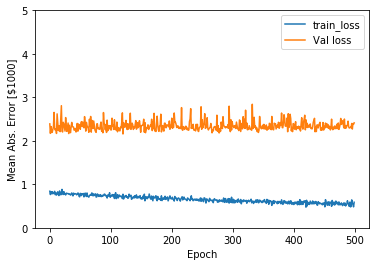

In [59]:
def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs. Error [$1000]')
    plt.plot(history.epoch, np.array(history.history['mean_absolute_error']), label='train_loss')
    plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']), label='Val loss')
    plt.legend()
    plt.ylim([0, 5])
plot_history(history)

## Adding Keras early stopping callback

In [60]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
history = model.fit(train_data, train_labels, epochs=epochs, validation_split=0.2, verbose=0, callbacks=[early_stop, PrintDot()])


.................................

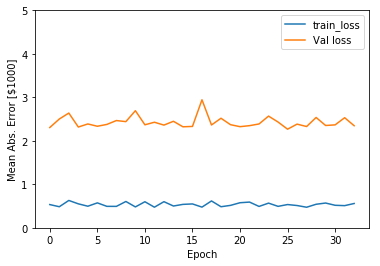

In [61]:
plot_history(history)

(3.370143369175627, 52.229856630824365, 4.116007858291104, 51.716347164139314)

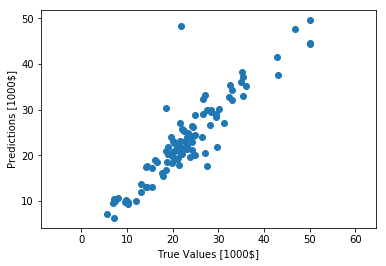

In [62]:
test_predictions = model.predict(test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [1000$]')
plt.ylabel('Predictions [1000$]')
plt.axis('equal')

Text(0,0.5,'Count')

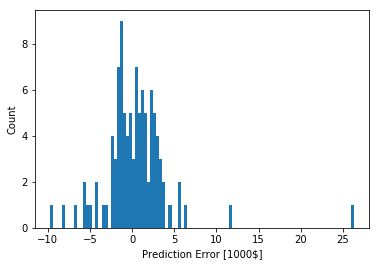

In [63]:
error = test_predictions - test_labels
plt.hist(error, bins = 100)
plt.xlabel("Prediction Error [1000$]")
plt.ylabel('Count')

## Conclusion

Mean Squared Error (MSE) is a common loss function used for regression problems (different than classification problems).

Similarly, evaluation metrics used for regression differ from classification. A common regression metric is Mean Absolute Error (MAE).

When input data features have values with different ranges, each feature should be scaled independently.

If there is not much training data, prefer a small network with few hidden layers to avoid overfitting.

Early stopping is a useful technique to prevent overfitting.